In [1]:
import segmentation_models_pytorch as smp
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights, lraspp_mobilenet_v3_large, deeplabv3_resnet101

#Hyperparamters
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet' #pretrained weighting
#CLASSES = ["background", "skin", "nose", "right_eye", "left_eye", "right_brow", "left_brow", "right_ear", "left_ear", "mouth_interior", "top_lip", "bottom_lip", "neck", "hair", "beard", "clothing", "glasses", "headwear", "facewear"]
ACTIVATION = "sigmoid" # softmax2d for multiclass segmentation
num_classes = 11

"""
aux_params=dict(
    pooling='avg',       # one of 'avg', 'max'
    classes=num_classes, 
    activation = None
)
"""

#DEEPLABV3+

deeplab = smp.DeepLabV3Plus(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
    #encoder_depth = 18,
    #decoder_channels = 18,
    #aux_params=aux_params
)


#UNET
unet = smp.Unet(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
    #encoder_depth = 18,
    #decoder_channels = 18,
    decoder_use_batchnorm = True,
    #aux_params=aux_params
)

fcn = smp.FPN(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
)

mobile = smp.Unet(
    in_channels=3,
    encoder_name="mobilenet_v2", 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
    decoder_use_batchnorm = True,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [2]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row (Original Image: Ground Truth : Predicted)
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        if name == "original_image":
          #print(image.shape)
          plt.title(name.replace('_',' ').title(), fontsize=20)
          plt.imshow(image)
        else:
          #print(image.shape)
          # get title from the parameter names
          plt.title(name.replace('_',' ').title(), fontsize=20)
          plt.imshow(image)
    plt.show()

#Function to reverse one-hot-encode an image
def reverse_one_hot(image):
    #argmax to return the indices of the maximum values along an axis. 
    x = np.argmax(image, axis = -3)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.numpy().astype(int)]

    return x

In [3]:
#import torchvision.transforms as T
#import torchvision.transforms.functional as F
import albumentations as albu
import random
import scipy
import torch
import os
import cv2
import numpy as np
#from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import re

SIZEX = 128
SIZEY = 128

rgb_vals = [ 0,1,2,3,4,5,6,7,8,9,10]


def to_tensor(x, **kwargs):
    x_t = x.transpose(2, 0, 1).astype('float32')
    #print("XTSHAPE", x_t.shape)
    return x_t


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def get_training_augmentation():
    train_transform = [

        #albu.HorizontalFlip(p=0.5),
        albu.Rotate((-18,18)),
        albu.PadIfNeeded(min_height=SIZEY, min_width=SIZEY, always_apply=True, border_mode=0),
        #albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.Perspective(p=0.5),
        albu.GaussNoise(p=0.2),
        albu.OneOf([albu.CLAHE(p=1),albu.RandomBrightness(p=1),albu.RandomGamma(p=1),],p=0.9,),
        albu.OneOf([albu.Sharpen(p=1),albu.Blur(blur_limit=3, p=1),],p=0.9,),albu.OneOf([albu.RandomContrast(p=1),albu.HueSaturationValue(p=1),],p=0.9,),
    ]

    return albu.Compose(train_transform)


def transformation_augs():
    train_transform = [
        #albu.HorizontalFlip(p=0.5),

    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(SIZEY, SIZEY)
    ]
    return albu.Compose(test_transform)

class MyDataSet(torch.utils.data.Dataset):

  #CLASSES =  ["background","facial_skin","left_brow","right_brow","left_eye","right_eye", "nose","upper_lip","inner_mouth","lower_lip","hair"]

  def __init__(self, images_dir, masks_dir, coords_dir, preprocessing=None, classes=None,augmentation=None):
    super(MyDataSet, self).__init__()
    
    # store the augmented tensors tensors
    #self._x, self._y = x,y
    self.preprocessing = preprocessing
    self.augmentation = augmentation

    self.image_ids = os.listdir(images_dir)

    self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.image_ids]
    self.masks_fps = [os.path.join(masks_dir, mask_id.replace("jpg","png")) for mask_id in self.image_ids]
    self.coords_fps = [os.path.join(coords_dir, coords_id.replace("jpg", "txt")) for coords_id in self.image_ids]

  def __len__(self):
    # a DataSet must know it size
    return len(self.images_fps)

  def __getitem__(self, i):

    image = cv2.imread(self.images_fps[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_GRAYSCALE)

    #plt.imshow(mask)
    #plt.show
    #plt.imshow(image)

    # crop to center face
    smallest_x = 99999
    smallest_y = 99999
    biggest_x = -99999
    biggest_y = -99999
    with open(self.coords_fps[i], 'rb') as f:

      contents = str(f.read()).split("\\n")
      contents = [[int(float(single.replace("\\r", "").
                             replace("'", "").replace("b", "").replace("\\x1a", "")
                             )) for single in pair.split(" ")] for pair in contents[2:-2]]
      try:
        
        #print(contents)

        contents = np.array(contents)
        for pair in contents:
          #plt.scatter((pair[0]), (pair[1]), color="red")

          if (pair[0]) < smallest_x:
            smallest_x = (pair[0])
          
          if (pair[0]) > biggest_x:
            biggest_x = (pair[0])

          if (pair[1]) < smallest_y:
            smallest_y = (pair[1])
          
          if (pair[1]) > biggest_y:
            biggest_y = (pair[1])


        crop_coords = (int(smallest_x), int(biggest_x), int(smallest_y), int(biggest_y))

        image = image[smallest_y: biggest_y, smallest_x:biggest_x]
        mask = mask[smallest_y: biggest_y, smallest_x:biggest_x]


        mask = cv2.resize(mask, (SIZEY, SIZEY))
        image = cv2.resize(image, (SIZEY, SIZEY))
        mask = np.expand_dims(mask,2)
      except:
        #item corrutpted
        return self.__getitem__(i-1)
    # smooth mask
    # mask = mask = scipy.ndimage.median_filter(mask, 5)

    # apply augmentations
    if self.augmentation:
        sample = self.augmentation(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']
    
    # apply preprocessing
    if self.preprocessing:
        sample = self.preprocessing(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']

    #onehot
    one_hot_Y = torch.nn.functional.one_hot(torch.tensor(mask).to(torch.int64), 11).permute(0,3,1,2).float()

    return (image, one_hot_Y.squeeze(0))


train_x_path = "/home/nathan/Documents/final_project/datasets/LaPa/train/images"
train_y_path = "/home/nathan/Documents/final_project/datasets/LaPa/train/labels"
train_coords_path = "/home/nathan/Documents/final_project/datasets/LaPa/train/landmarks"

val_x_path = "/home/nathan/Documents/final_project/datasets/LaPa/val/images"
val_y_path = "/home/nathan/Documents/final_project/datasets/LaPa/val/labels"
val_coords_path = "/home/nathan/Documents/final_project/datasets/LaPa/val/landmarks"

test_x_path = "/home/nathan/Documents/final_project/datasets/LaPa/test/images"
test_y_path = "/home/nathan/Documents/final_project/datasets/LaPa/test/labels"
test_coords_path = "/home/nathan/Documents/final_project/datasets/LaPa/test/landmarks"

train_ds = MyDataSet(train_x_path, train_y_path, train_coords_path, preprocessing=get_preprocessing(preprocessing_fn),augmentation=get_training_augmentation())
val_ds = MyDataSet(val_x_path, val_y_path, val_coords_path, preprocessing=get_preprocessing(preprocessing_fn),augmentation=get_validation_augmentation())
test_ds = MyDataSet(test_x_path, test_y_path, test_coords_path, preprocessing=get_preprocessing(preprocessing_fn),augmentation=get_validation_augmentation())

/home/nathan/miniconda3/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/nathan/miniconda3/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


0 : (3, 128, 128) torch.Size([11, 128, 128])


/tmp/ipykernel_28255/3609109764.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)


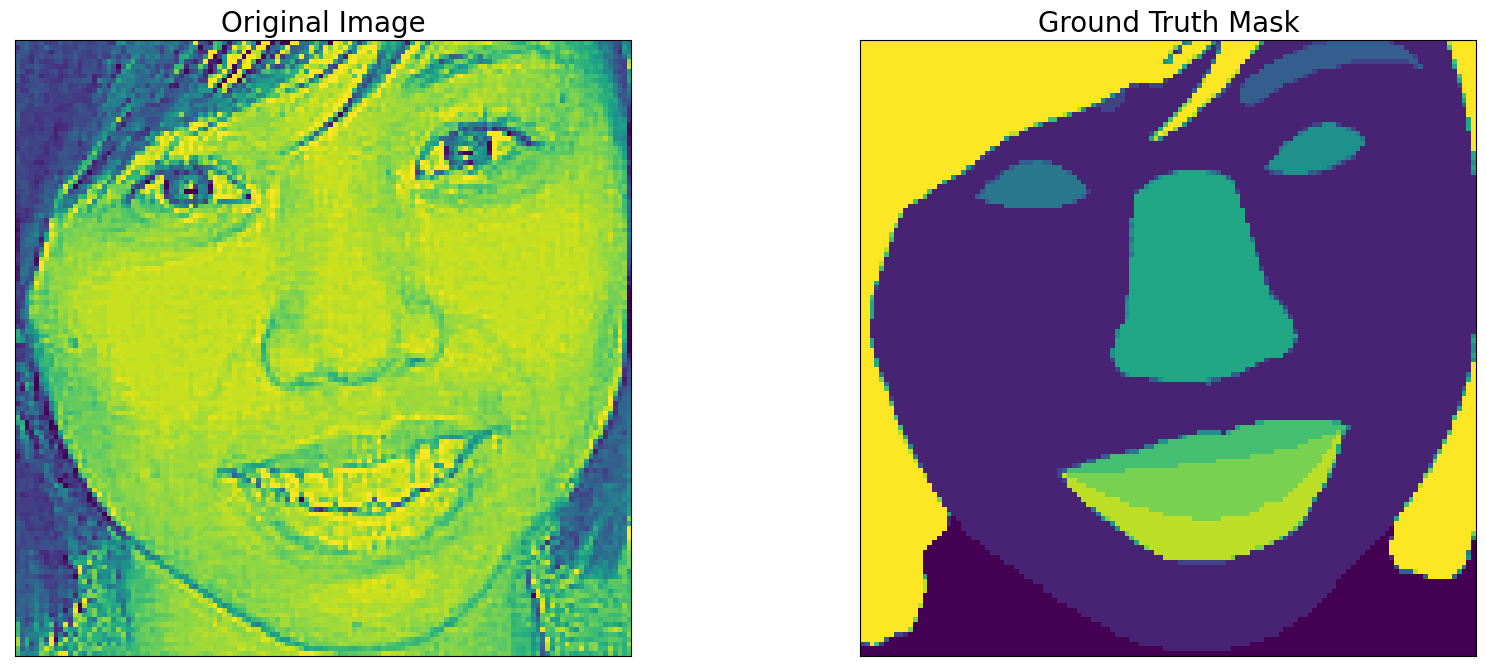

1 : (3, 128, 128) torch.Size([11, 128, 128])


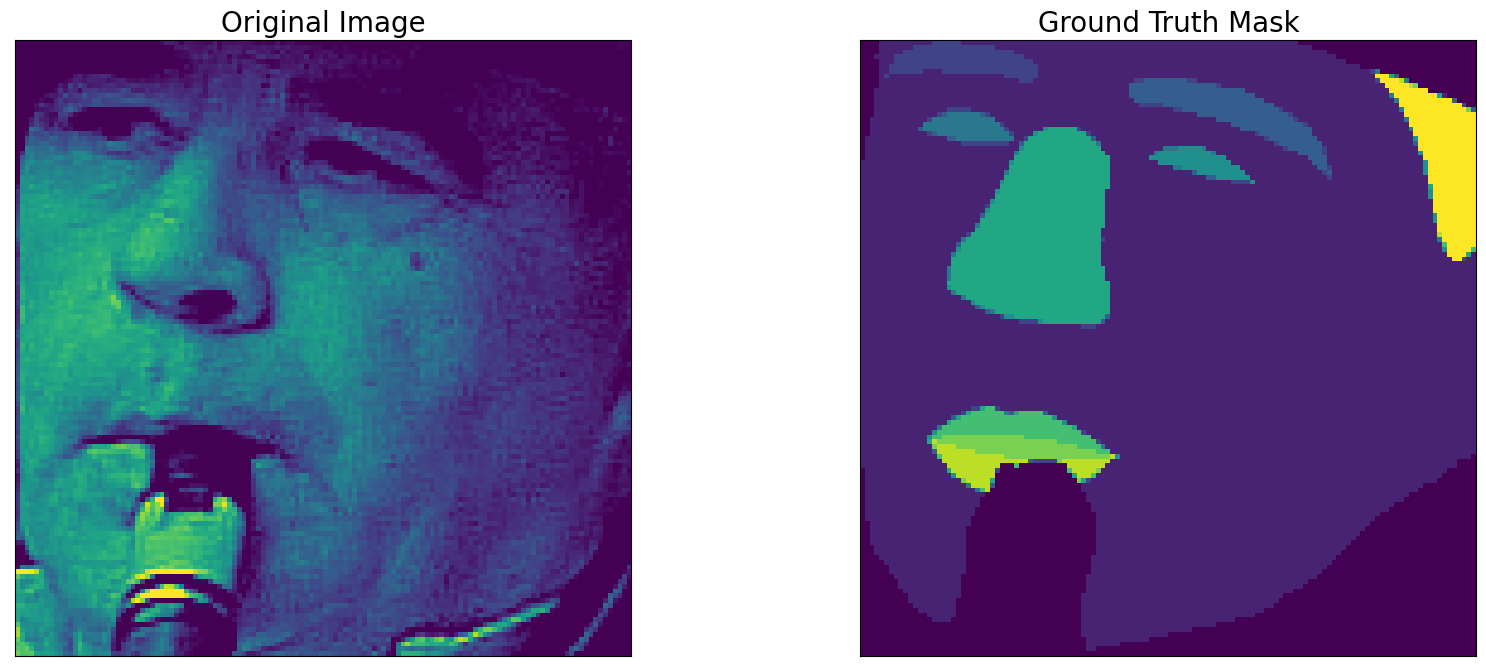

0 : (3, 128, 128) torch.Size([11, 128, 128])


/tmp/ipykernel_28255/3609109764.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)


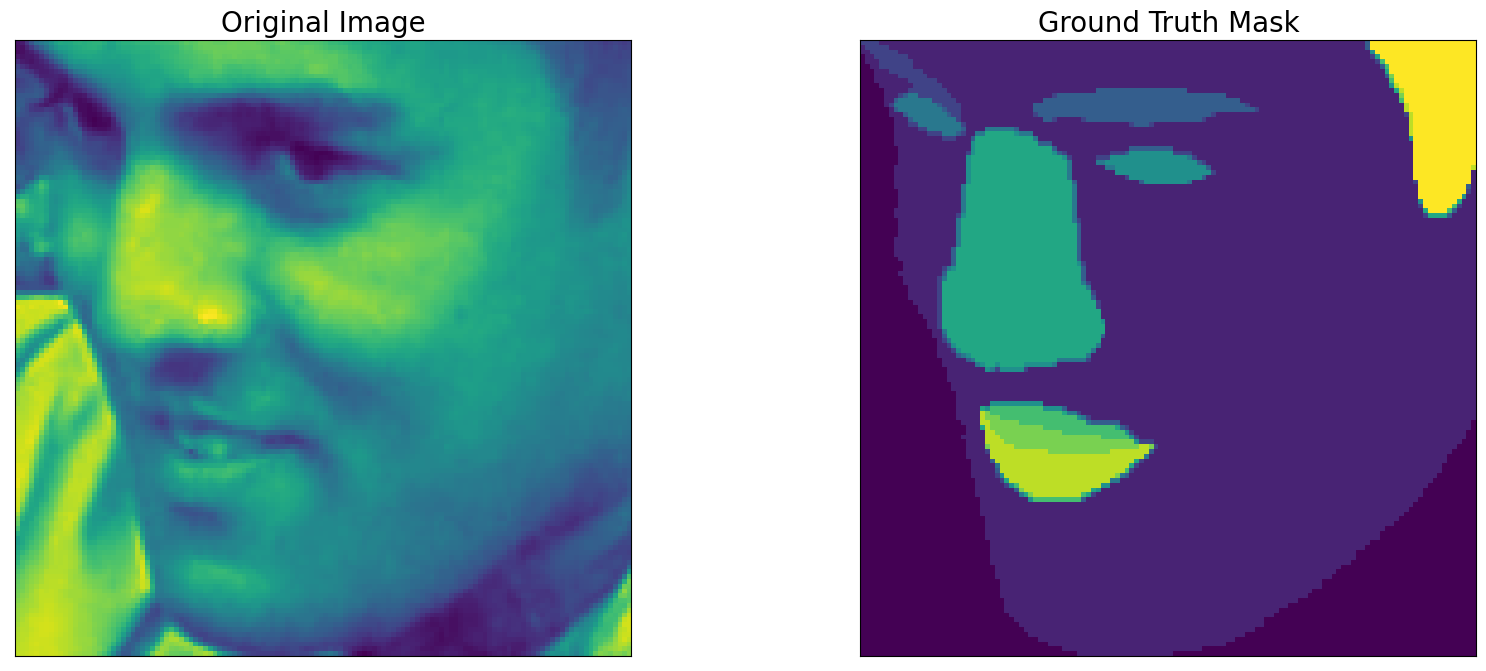

1 : (3, 128, 128) torch.Size([11, 128, 128])


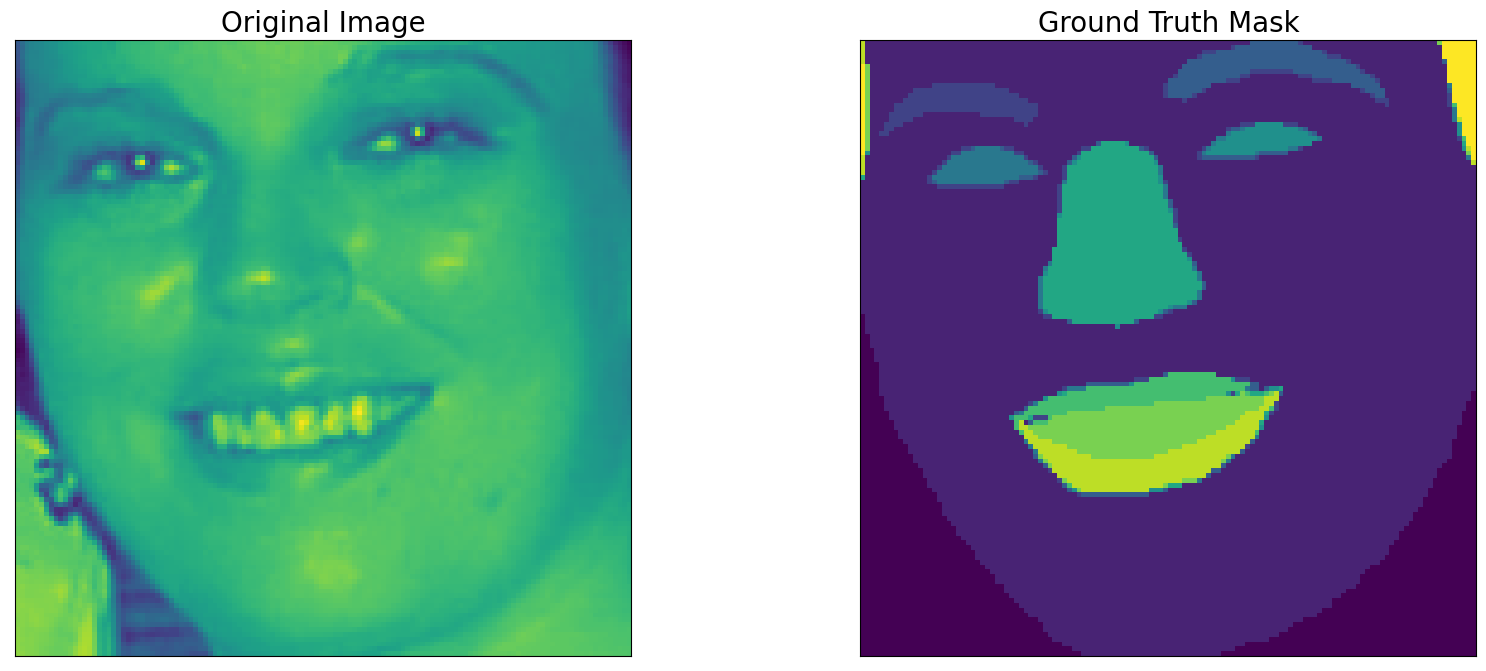

In [4]:
from matplotlib import pyplot as plt

for x in range(2):

  image_vis, gt_mask = train_ds[x]
  print(x, ":", image_vis.shape, gt_mask.shape)

  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)
  binary_smoothed = scipy.signal.medfilt (gt_mask, 9)

  visualize(
      original_image = image_vis[0,::],
      ground_truth_mask = gt_mask
  )

for x in range(2):

  image_vis, gt_mask = val_ds[x]
  print(x, ":", image_vis.shape, gt_mask.shape)

  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)
  binary_smoothed = scipy.signal.medfilt (gt_mask, 9)

  visualize(
      original_image = image_vis[0,::],
      ground_truth_mask = gt_mask
  )

#np.unique(image_vis)

### Data Loader

In [5]:
from torch.utils.data import DataLoader

# Get train and val data loaders
train_loader = DataLoader(train_ds, batch_size=24, shuffle=True, num_workers=22)
valid_loader = DataLoader(val_ds, batch_size=24, shuffle=False, num_workers=22)

print(len(train_loader))

757


/home/nathan/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
image_vis, gt_mask = next(iter(train_loader))
print(image_vis.shape)
print(gt_mask.shape)

torch.Size([24, 3, 128, 128])
torch.Size([24, 11, 128, 128])


## Hyper Params

In [7]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn import preprocessing

weights_per_image = []
for x, pair in enumerate(train_ds):
  mask = pair[1]
  weights = []
  for layer in np.array(mask):
    count = np.sum(layer == 1)
    if count != 0:
      weights.append(count)
    else:
      weights.append(0)
  if x == 100:
    break

  weights_per_image.append(weights)

# average down collumns
wpi_numpy = np.array(weights_per_image)
wpi_avs = wpi_numpy.mean(axis=0)

normedWeights = [1 - (x / sum(wpi_avs)) for x in wpi_avs]
normedWeights = torch.FloatTensor(normedWeights)
normedWeights



tensor([0.9045, 0.3298, 0.9816, 0.9842, 0.9885, 0.9885, 0.9198, 0.9867, 0.9863,
        0.9787, 0.9514])

In [8]:
from segmentation_models_pytorch import utils
import os

# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set device: `cuda` or `cpu`
#"cuda" if torch.cuda.is_available() else
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#[0.1, 1, 1, 1, 1, 1, 0.8, 1, 0.8, 1, 0.1]
#weights = weights=torch.tensor()
# define loss function
#loss = smp.utils.losses.BCELoss()
#loss = FocalLoss("multilabel", alpha=0.25, gamma=4)
#weights = torch.tensor([0.7526, 0.4953, 0.9898, 0.9910, 0.9942, 0.9942, 0.9579, 0.9940, 0.9931,
#        0.9895, 0.8484])

#loss = SoftBCEWithLogitsLoss(pos_weight=normedWeights)
loss = smp.utils.losses.CrossEntropyLoss(weight=normedWeights)

# define evalusation metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]


## Train Model

In [9]:
import matplotlib.pyplot as plt

def train_model(model, train_loader_given, valid_loader_given, saveas, epoch):

    #clear CUDA cache
    torch.cuda.empty_cache()

    # define optimizer
    optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.001)])
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0005)
    #optimizer = torch.optim.NAdam(model.parameters(), lr=0.001)

    # define learning rate scheduler
    #lr_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer)

    #define train ecpochs w/ our hyperparams
    train_epoch = smp.utils.train.TrainEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        optimizer=optimizer,
        device=DEVICE,
        verbose=True,
    )

    #define train ecpochs w/ our hyperparams
    valid_epoch = smp.utils.train.ValidEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        device=DEVICE,
        verbose=True,
    )

    if TRAINING:

        best_iou_score = 0.0
        train_logs_list, valid_logs_list = [], []

        #Keep track of epoch BCE and IoU for graph plots
        epoch_count = []
        v_bce = []
        v_ious = []

        t_bce = []
        t_ious = []

        i = 0
        while i < epoch:
            i +=1 

            # Perform training & validation
            print('\nEpoch: {}'.format(i))
            train_logs = train_epoch.run(train_loader_given)
            valid_logs = valid_epoch.run(valid_loader_given)
            #lr_scheduler.step()

            #log
            train_logs_list.append(train_logs)
            valid_logs_list.append(valid_logs)

            # Save model if a better val IoU score is obtained
            if best_iou_score < valid_logs['iou_score']:
                best_iou_score = valid_logs['iou_score']
                torch.save(model, saveas)
                print('Model saved!')

            if best_iou_score>0.8:
              optimizer.param_groups[0]['lr'] = 1e-5
              print('Decrease decoder learning rate to 1e-5!')
                
            # Append results to graphs:
           # v_bce.append(valid_logs['bce_loss'])
            v_ious.append(valid_logs['iou_score'])
            
            #t_bce.append(train_logs['bce_loss'])
            t_ious.append(train_logs['iou_score'])
            
            epoch_count.append(i)
        
            # Plot graph every 2 epochs
            if i % 2 ==0:
                #plt.plot(epoch_count,t_bce, label="Train ce")
#plt.plot(epoch_count,v_bce, label="Valid ce")
                #.legend(loc="upper left")
               # plt.xlabel("Epochs")
               # plt.ylabel("BCE Loss")
                plt.show()
                plt.plot(epoch_count,t_ious, label="Train IoU")
                plt.plot(epoch_count,v_ious, label="Valid IoU")
                plt.legend(loc="upper left")
                plt.xlabel("Epochs")
                plt.ylabel("IoU")
                plt.show()


### Function to view train model precitions

In [10]:
! pip install torchmetrics

/bin/bash: /home/nathan/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [11]:
from sklearn.metrics import jaccard_score, f1_score
import tensorflow as tf
from torchmetrics.classification import F1Score, BinaryF1Score, MulticlassF1Score, JaccardIndex
from torchmetrics import Dice
from sklearn.preprocessing import MultiLabelBinarizer
from torchvision.utils import save_image
from PIL import Image
from skimage.transform import resize
from scipy.ndimage.filters import gaussian_filter

def average(lst):
    return sum(lst) / len(lst)

def view_predictions(model, ds, numm_classes ):

    ious = []
    f1s = []

    #predict
    for idx in range(len(ds)):

        image, gt_mask = ds[idx]
        image = image
        image_vis = image
        image_vis = np.transpose(image_vis,(1,2,0))
        #print("vis:",image_vis.shape)
        #print("im:",image.shape)
        
        x_tensor = torch.tensor(image).to(DEVICE).unsqueeze(0)
        #print("X_TENSOR:", x_tensor, x_tensor.shape)
        # Predict test image
        pred_mask = model(x_tensor)
        #print("predraw", pred_mask.shape)
        #print("gtraw", gt_mask.shape)
        pred_mask = pred_mask.detach().squeeze().cpu().numpy()
        # Convert pred_mask from `CHW` format to `HWC` format
        #print(pred_mask.shape)
        # Get prediction channel corresponding to face
        pred_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(pred_mask)), rgb_vals)
        #print(pred_mask.shape)
        
        # Convert gt_mask from `CHW` format to `HWC` format
        #print(gt_mask.shape)
        gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)
        
        #get IoU score
        m = tf.keras.metrics.MeanIoU(num_classes=numm_classes)
        m.update_state(gt_mask, pred_mask)
        iou = m.result().numpy()
        #print("MEAN IoU:" , iou)
        ious.append(iou)

        metric = MulticlassF1Score(num_classes=numm_classes, average=None, labels=np.unique(pred_mask) ,validate_args=True)
        #metric = JaccardIndex(task="multiclass",num_classes=numm_classes, average=None, labels=np.unique(pred_mask) ,validate_args=True)
        f1 = metric(torch.tensor(gt_mask), torch.tensor(pred_mask))
        if len(f1) == num_classes:
          f1[f1 <0.1] = np.nan
          #print(f1)
          f1s.append(np.array(f1))

        if idx == 2:
          visualize(
              original_image = image[0,::],
              ground_truth_mask = gt_mask,
              predicted_mask = pred_mask,
          )

    
    fs1_numpy = np.array(f1s)
    av_f1s = np.nanmean(fs1_numpy, axis=0)
    #av_f1s = fs1_numpy.mean(axis=0)
    av_f1s_av = av_f1s.mean(axis=0)

    print ("Dataset MIoU = ", average(ious))
    print ("Dataset F1 = ", av_f1s)
    print ("Dataset F1 av = ", av_f1s_av)

2023-02-17 02:52:09.651390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 02:52:10.207145: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-17 02:52:11.874070: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nathan/miniconda3/lib/python3.9/site-packages/cv2/../../lib64::/home/nathan/miniconda3/lib/:/home/nathan/miniconda3/lib/:/home/nathan/miniconda3/lib/
2023-02-17 02:52:11.874297: W tensorflow/stream_executor

# Predict with models

In [12]:
#train_model(unet, train_loader, valid_loader, "/home/nathan/Documents/final_project/saved_models/lapa/unet.pth", 20)
#train_model(fcn, train_loader, valid_loader, "/home/nathan/Documents/final_project/saved_models/lapa/fcn.pth", 20)
#train_model(mobile, train_loader, valid_loader, "/home/nathan/Documents/final_project/saved_models/lapa/mobile.pth", 20)
#train_model(deeplab, train_loader, valid_loader, "/home/nathan/Documents/final_project/saved_models/lapa/deeplab.pth", 20)

### Load and view model predictions

In [13]:
"""
print("LAPA:")

model = torch.load("/home/nathan/Documents/final_project/saved_models/lapa/deeplab.pth", map_location=DEVICE)
view_predictions(model,test_ds, num_classes)

model = torch.load("/home/nathan/Documents/final_project/saved_models/lapa/fcn.pth", map_location=DEVICE)
view_predictions(model,test_ds, num_classes)

model = torch.load("/home/nathan/Documents/final_project/saved_models/lapa/mobile.pth", map_location=DEVICE)
view_predictions(model,test_ds, num_classes)

model = torch.load("/home/nathan/Documents/final_project/saved_models/lapa/unet.pth", map_location=DEVICE)
view_predictions(model,test_ds, num_classes)
"""


'\nprint("LAPA:")\n\nmodel = torch.load("/home/nathan/Documents/final_project/saved_models/lapa/deeplab.pth", map_location=DEVICE)\nview_predictions(model,test_ds, num_classes)\n\nmodel = torch.load("/home/nathan/Documents/final_project/saved_models/lapa/fcn.pth", map_location=DEVICE)\nview_predictions(model,test_ds, num_classes)\n\nmodel = torch.load("/home/nathan/Documents/final_project/saved_models/lapa/mobile.pth", map_location=DEVICE)\nview_predictions(model,test_ds, num_classes)\n\nmodel = torch.load("/home/nathan/Documents/final_project/saved_models/lapa/unet.pth", map_location=DEVICE)\nview_predictions(model,test_ds, num_classes)\n'

## view results after label adapting

fpn


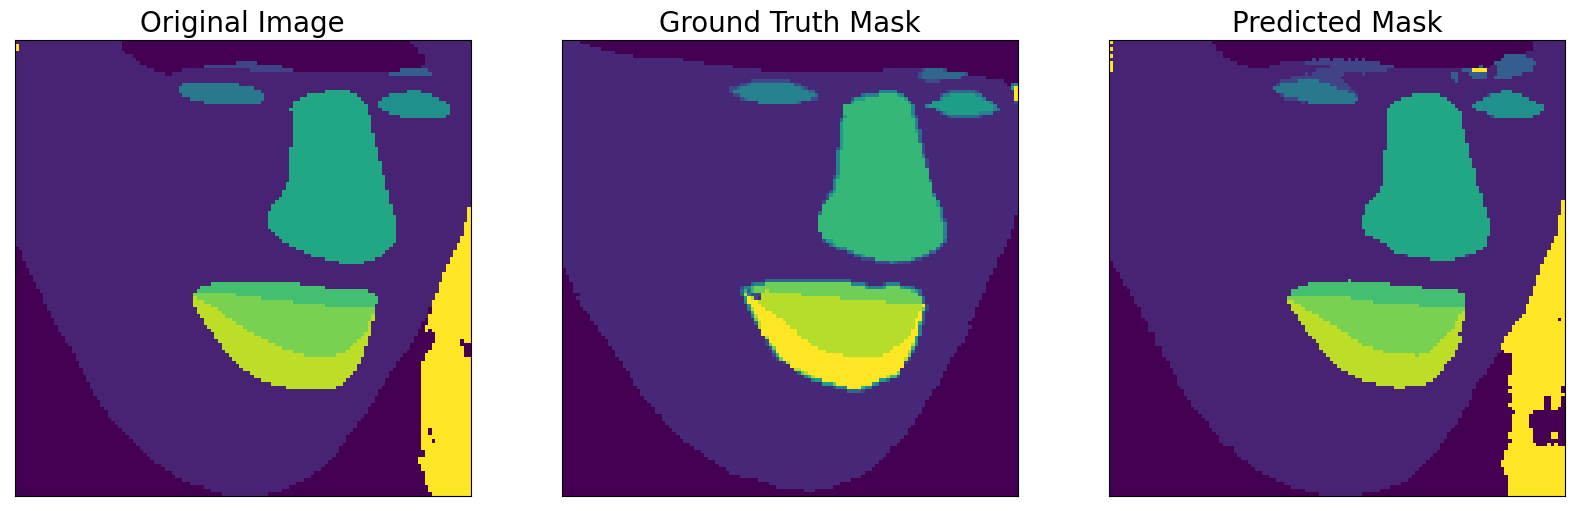

Dataset F1 =  [0.866094   0.9669555  0.7019309  0.75156385 0.72011286 0.7210408
 0.9450466  0.79371786 0.6951682  0.8443353  0.74070644]
Dataset F1 av =  0.79515207
mobile


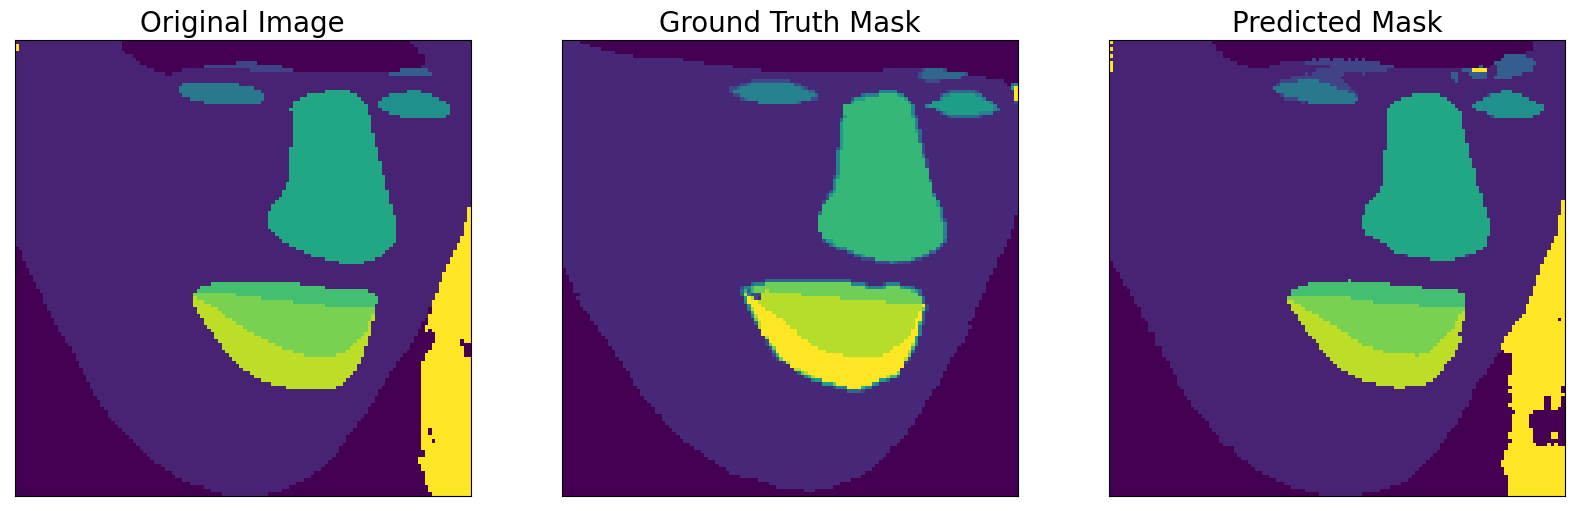

Dataset F1 =  [0.866094   0.9669555  0.7019309  0.75156385 0.72011286 0.7210408
 0.9450466  0.79371786 0.6951682  0.8443353  0.74070644]
Dataset F1 av =  0.79515207
unet


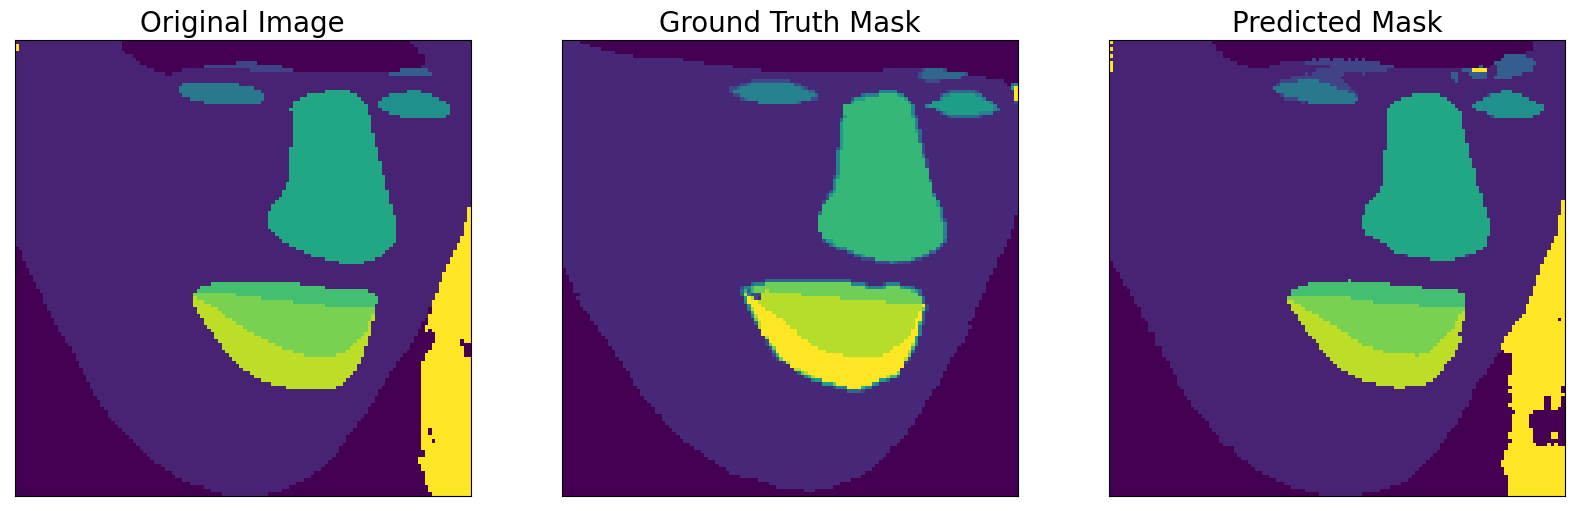

Dataset F1 =  [0.866094   0.9669555  0.7019309  0.75156385 0.72011286 0.7210408
 0.9450466  0.79371786 0.6951682  0.8443353  0.74070644]
Dataset F1 av =  0.79515207


In [15]:
import label_test_script

print("deeplab:")
model = torch.load("/home/nathan/Documents/final_project/saved_models/lapa/deeplab.pth", map_location=DEVICE)
label_test_script.view_label_predictions(model,test_ds, num_classes)

print("fpn")
model = torch.load("/home/nathan/Documents/final_project/saved_models/lapa/fcn.pth", map_location=DEVICE)
label_test_script.view_label_predictions(model,test_ds, num_classes)

print("mobile")
model = torch.load("/home/nathan/Documents/final_project/saved_models/lapa/mobile.pth", map_location=DEVICE)
label_test_script.view_label_predictions(model,test_ds, num_classes)

print("unet")
model = torch.load("/home/nathan/Documents/final_project/saved_models/lapa/unet.pth", map_location=DEVICE)
label_test_script.view_label_predictions(model,test_ds, num_classes)